# Audio Description of image for visually blind Person

This model uses seq2seq architecure with teacher forcing to caption images from MS COCO dataset.

## Importing Libraries

In [1]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import os
import json
import time
from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle

keras = tf.keras


## Setting config parameters

In [2]:

max_cap_len = 15  # Determines max length of captioning sentences
img_dimensions = 299 # Determines the height and width of images
num_words = 10000 # Determines vocab size to tokenize and train on
encoding_size = 512 # Determines dimension of the encodings of images
LSTM_size = 512  
batch_size = 128
n_epochs = 15
Buffer_size = 1000
validation_and_test_split = 0.2
test_to_val_split = 0.5
num_examples = None # Determines number of overall read samples. If set to none all samples will be read as long as they don't exceed max_cap_len

# Data Preprocessing¶


### Downloading the MS COCO dataset

Both this cell and the one below it were copied from a google documentation.

I have done some editing like stripping out most of 'a', 'an' and 'the' words as they had little value and were too common.

Link of the google doucmenatin:

https://www.tensorflow.org/tutorials/text/image_captioning#model

In [3]:
pwd

'/content'

In [4]:
os.path.abspath('.')

'/content'

In [5]:
annotation_folder = '/annotations/'

annotation_zip = tf.keras.utils.get_file('captions.zip',
                                          cache_subdir=os.path.abspath('.'),
                                          origin = 'http://images.cocodataset.org/annotations/annotations_trainval2014.zip',
                                          extract = True)
annotation_file = os.path.dirname(annotation_zip)+'/annotations/captions_train2014.json'
os.remove(annotation_zip)

# Download image files
image_folder = '/train2014/'

image_zip = tf.keras.utils.get_file('train2014.zip',
                                      cache_subdir=os.path.abspath('.'),
                                      origin = 'http://images.cocodataset.org/zips/train2014.zip',
                                      extract = True)
PATH = os.path.dirname(image_zip) + image_folder
os.remove(image_zip)

13510574080/13510573713 [==============================] - 215s 0us/step


### Reading the data

In [6]:
annotation_file=os.path.dirname(annotation_zip)+ '/annotations/captions_train2014.json'
with open(annotation_file,'r') as f:
  annotations=json.load(f)

# Store captions and image name in vectors
all_captions=[]
all_img_name_vector=[]

for annot in annotations['annotations']:
  caption=annot['caption']
  

  # Removing the word 'a' from captions
  caption=caption.replace(" a "," ")
  caption = caption.replace("A ","")
  #Removing the word 'an' from captions
  caption = caption.replace("An ","")
  caption = caption.replace(" an "," ")
  #Removing the word 'the' from captions
  caption = caption.replace(" the "," ")
  caption = caption.replace("The ","")

  #Load only captions that don't exceed maximum length
  if len(caption.split(' '))>max_cap_len:
    continue
  else:
    caption='<sos> ' + caption + ' <eos>'
    image_id=annot['image_id']
    full_coco_image_path=PATH + 'COCO_train2014_' + '%012d.jpg' % (image_id)

    all_img_name_vector.append(full_coco_image_path)
    all_captions.append(caption)

  
# Shuffle captions and image_names together
# Set a random state
train_captions, img_name_vector = shuffle(all_captions,
                                          all_img_name_vector,
                                          random_state=42)
train_captions = train_captions[:num_examples]
img_name_vector = img_name_vector[:num_examples]

caption_train, captions_test, img_name_vector_train, img_name_vector_test = train_test_split(train_captions,img_name_vector,
                                                                                                 test_size= validation_and_test_split)

caption_val, caption_test, img_name_vector_val, img_name_vector_test = train_test_split(captions_test,
                                                        img_name_vector_test,
                                                        test_size= test_to_val_split)
num_samples = len(img_name_vector)
assert len(train_captions) == len(img_name_vector)
print("Loaded %d samples" %(num_samples))
print("Loaded %d train samples" %(len(caption_train)))
print("Loaded %d valid samples" %(len(caption_val)))
print("Loaded %d test samples" %(len(caption_test)))



Loaded 409297 samples
Loaded 327437 train samples
Loaded 40930 valid samples
Loaded 40930 test samples


In [7]:
from pickle import dump,load

In [11]:
# # saving the file as a pickle object

# dump(caption_train,open('/content/drive/MyDrive/image_caption_data/caption_train.pkl', 'wb'))
# dump(caption_val,open('/content/drive/MyDrive/image_caption_data/caption_val.pkl', 'wb'))
# dump(caption_test,open('/content/drive/MyDrive/image_caption_data/caption_test.pkl', 'wb'))

# dump(img_name_vector_train,open('/content/drive/MyDrive/image_caption_data/img_name_vector_train.pkl', 'wb'))
# dump(img_name_vector_val,open('/content/drive/MyDrive/image_caption_data/img_name_vector_val.pkl', 'wb'))
# dump(img_name_vector_test,open('/content/drive/MyDrive/image_caption_data/img_name_vector_test.pkl', 'wb'))

# dump(img_name_vector,open('/content/drive/MyDrive/image_caption_data/img_name_vector.pkl', 'wb'))


In [12]:
caption_train = load(open('/content/drive/MyDrive/image_caption_data/caption_train.pkl', 'rb'))
caption_val = load(open('/content/drive/MyDrive/image_caption_data/caption_val.pkl', 'rb'))
caption_test = load(open('/content/drive/MyDrive/image_caption_data/caption_test.pkl', 'rb'))

img_name_vector_train = load(open('/content/drive/MyDrive/image_caption_data/img_name_vector_train.pkl', 'rb'))
img_name_vector_val = load(open('/content/drive/MyDrive/image_caption_data/img_name_vector_val.pkl', 'rb'))
img_name_vector_test = load(open('/content/drive/MyDrive/image_caption_data/img_name_vector_test.pkl', 'rb'))

img_name_vector = load(open('/content/drive/MyDrive/image_caption_data/img_name_vector.pkl', 'rb'))

# Exploratory data analysis

In [13]:
 caption_train[:10]
 

['<sos> Two giraffes walking around under trees in shade. <eos>',
 '<sos> plate with cheesy sandwich and silverware.  <eos>',
 '<sos> People are standing outside of old airplane. <eos>',
 '<sos> People waiting for subway train in station. <eos>',
 '<sos> Portland Timbers airplane is parked at airport terminal. <eos>',
 '<sos> there is man that is fixing blanket <eos>',
 '<sos> man about to swing tennis racket on tennis court <eos>',
 '<sos> Restaurant workers in clean kitchen making orders. <eos>',
 '<sos> photograph of woman wave boarding with mountains in background. <eos>',
 '<sos> female officer is wearing tie and sweater <eos>']

In [15]:
img_name_vector_train[:10]

['/content/train2014/COCO_train2014_000000093922.jpg',
 '/content/train2014/COCO_train2014_000000540100.jpg',
 '/content/train2014/COCO_train2014_000000179418.jpg',
 '/content/train2014/COCO_train2014_000000445892.jpg',
 '/content/train2014/COCO_train2014_000000455015.jpg',
 '/content/train2014/COCO_train2014_000000264165.jpg',
 '/content/train2014/COCO_train2014_000000517026.jpg',
 '/content/train2014/COCO_train2014_000000383949.jpg',
 '/content/train2014/COCO_train2014_000000541174.jpg',
 '/content/train2014/COCO_train2014_000000326237.jpg']

### Tokenizing and padding captions

In [18]:
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences

In [19]:
# Tokenizer -This class allows to vectorize a text corpus, by turning each text into either a sequence of integers 
#(each integer being the index of a token in a dictionary)
tok=Tokenizer(num_words=num_words,filters="!?,'()_-+=&*$#@.",oov_token="<unk>")   #num_words- max. no of words in dictionary
print(tok.word_index)

tok.fit_on_texts(caption_train)
print('Vocabulary:',tok.word_index)
captions_train=tok.texts_to_sequences(caption_train)
if num_words== None:
  words=len(tok.word_index)
else:
  words=num_words
captions_train=pad_sequences(captions_train,padding='post',maxlen=max_cap_len+2)
print("Examlpe:", captions_train[np.random.randint(low=0, high= len(captions_train) - 1,size=1)[0]])
print("Found %d unique words" %(words))

{}
Vocabulary: {'<unk>': 1, '<sos>': 2, '<eos>': 3, 'on': 4, 'of': 5, 'in': 6, 'with': 7, 'and': 8, 'is': 9, 'man': 10, 'to': 11, 'a': 12, 'sitting': 13, 'two': 14, 'standing': 15, 'at': 16, 'people': 17, 'are': 18, 'next': 19, 'white': 20, 'woman': 21, 'street': 22, 'table': 23, 'holding': 24, 'that': 25, 'it': 26, 'person': 27, 'some': 28, 'large': 29, 'down': 30, 'top': 31, 'group': 32, 'up': 33, 'field': 34, 'small': 35, 'near': 36, 'tennis': 37, 'black': 38, 'his': 39, 'front': 40, 'train': 41, 'plate': 42, 'room': 43, 'riding': 44, 'dog': 45, 'red': 46, 'young': 47, 'by': 48, 'cat': 49, 'water': 50, 'baseball': 51, 'playing': 52, 'walking': 53, 'has': 54, 'bathroom': 55, 'while': 56, 'sign': 57, 'blue': 58, 'food': 59, 'kitchen': 60, 'grass': 61, 'bus': 62, 'there': 63, 'parked': 64, 'pizza': 65, 'green': 66, 'snow': 67, 'building': 68, 'side': 69, 'looking': 70, 'bed': 71, 'other': 72, 'ball': 73, 'beach': 74, 'couple': 75, 'three': 76, 'boy': 77, 'for': 78, 'men': 79, 'toilet':

In [20]:
# tokenizing validation caption
captions_valid = tok.texts_to_sequences(caption_val)
captions_valid = pad_sequences(captions_valid, padding='post',maxlen=max_cap_len + 2)

In [21]:
captions_valid[0]

array([   2, 1821,   44,   83,    4, 1015,   22,    3,    0,    0,    0,
          0,    0,    0,    0,    0,    0], dtype=int32)

### Defining preprocessing functions of dataset
tf.data api is used for making efficient input pipelines as the data is huge for ram.

In [24]:
def load_img(path):
  img=tf.io.read_file(path)                   #Reads and outputs the entire contents of the input filename
  img=tf.image.decode_jpeg(img,channels=3)   #Decode a JPEG-encoded image to a uint8 tensor
  img=tf.image.resize(img,(img_dimensions,img_dimensions))     #resize the image to put into the inception model
  return img 


In [25]:
def preprocess_func(path_index,caption):
  #Reading the image
  path_index=tf.reshape(path_index,())
  path=tf.gather(img_name_vector_train,indices=path_index)    #Gather slices from params axis axis according to indices.
  img=load_img(path)
  # preeprocessing text
  teacher_caption=caption[:-1]
  tar_caption=caption[1:]

  h_and_c_init=tf.zeros((LSTM_size))

  return (img,h_and_c_init,teacher_caption),tar_caption

In [26]:
x=preprocess_func(0,caption[0])

In [27]:
 
def preprocess_func_val(path_index, caption): 
  #Reading the image
  path_index = tf.reshape(path_index, ())
  path = tf.gather(img_name_vector_val,indices=path_index)
  img = load_img(path)#/255.0
  #Preprocessing text
  teacher_caption = caption[:-1]
  tar_caption = caption[1:]

  h_and_c_init = tf.zeros((LSTM_size))
  
  return (img,h_and_c_init,teacher_caption), tar_caption

In [28]:
# Creating an array to index each img path for reading
path_index_vec_train=np.array(list(range(0,len(img_name_vector_train)))).reshape(-1,1)  #  We have provided column as 1 but rows as unknown . So we get result new shape as (r*c, 1).again compatible with original shape(r,c)
path_index_vec_val = np.array(list(range(0,len(img_name_vector_val)))).reshape(-1,1)

#train
dataset1_train=tf.data.Dataset.from_tensor_slices(path_index_vec_train)
dataset2_train=tf.data.Dataset.from_tensor_slices(captions_train)
dataset=tf.data.Dataset.zip((dataset1_train,dataset2_train))
dataset = dataset.map(preprocess_func, num_parallel_calls=tf.data.experimental.AUTOTUNE)

#validation
dataset1_val = tf.data.Dataset.from_tensor_slices(path_index_vec_val)
dataset2_val = tf.data.Dataset.from_tensor_slices(captions_valid)
dataset_val = tf.data.Dataset.zip((dataset1_val,dataset2_val))
dataset_val = dataset_val.map(preprocess_func_val, num_parallel_calls=tf.data.experimental.AUTOTUNE)



In [29]:
dataset = dataset.shuffle(Buffer_size).batch(batch_size,drop_remainder=True).prefetch(1)
dataset_val = dataset_val.shuffle(Buffer_size).batch(256,drop_remainder=True).prefetch(1)

Sample images and captions

Each image has single caption

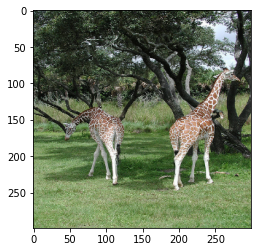

<sos> Two giraffes walking around under trees in shade. <eos>


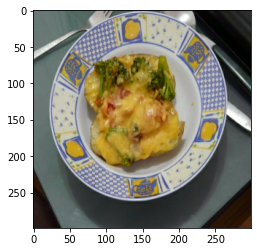

<sos> plate with cheesy sandwich and silverware.  <eos>


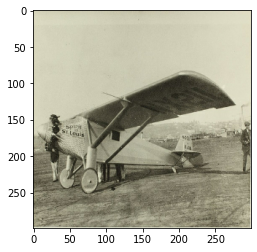

<sos> People are standing outside of old airplane. <eos>


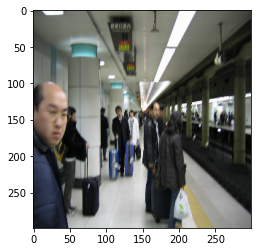

<sos> People waiting for subway train in station. <eos>


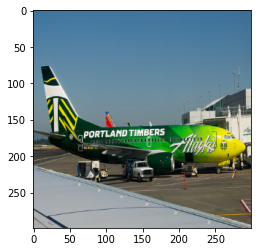

<sos> Portland Timbers airplane is parked at airport terminal. <eos>


In [30]:
for i in range(0,5):
  img=load_img(img_name_vector_train[i])
  img=img/255.0
  plt.imshow(img)
  plt.show();
  print(caption_train[i])

# Building the Model

## Model Structure and implementation details

Here we are using Local Attention(Bahdanau Attention)  with soft attention.
* Hard Attention- Hard attention is when, instead of weighted average of all hidden states, we use attention scores to select a single hidden state.
* Soft Attention- Soft attention is when we calculate the context vector as a weighted sum of the encoder hidden states

### Local Attention
As Global attention focus on all source side words for all target words, it is computationally very expensive and is impractical when translating 
for long sentences. To overcome this deficiency local attention chooses to focus only on a small subset of the hidden states of the encoder per
target word.



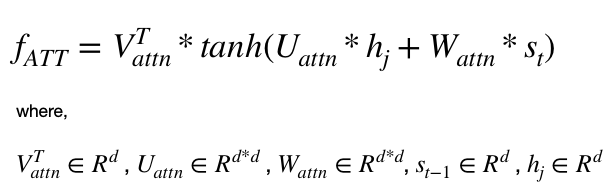

## Attention mechanism equations

 Every location of convolution layers corresponds to some location of image as shown below.


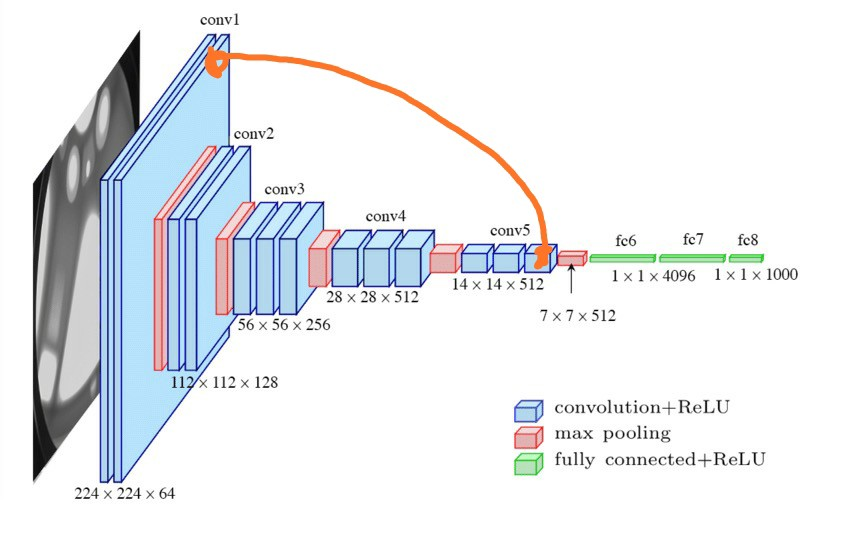

### just an example

Now, for example, the output of the 5th convolution layer of Inception is a 14 * 14 * 512 size feature map. <br>
This 5th convolution layer has 14*14 pixel locations which corresponds to certain portion in image, that means we have 196 such pixel locations.
And finally, we can treat these 196 locations(each having 512 dimensional representation) . <br>
The model will then learn an attention over these locations(which in turn corresponds to actual locations in the images).

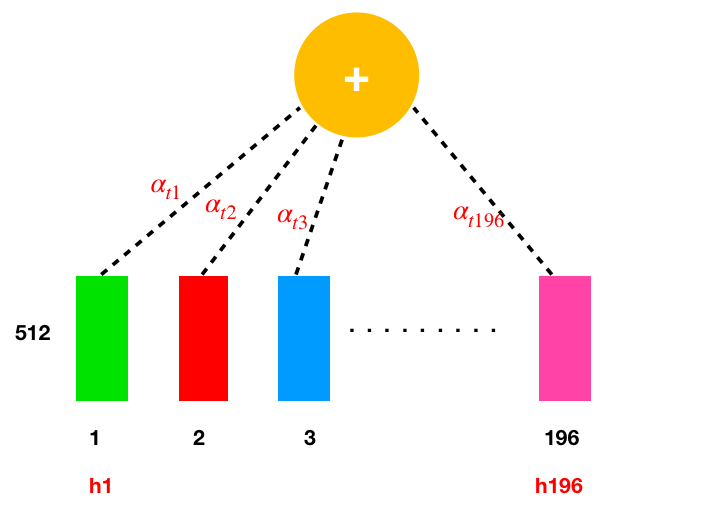

Let’s discuss equations for Local Attention and Global Attention with General score :




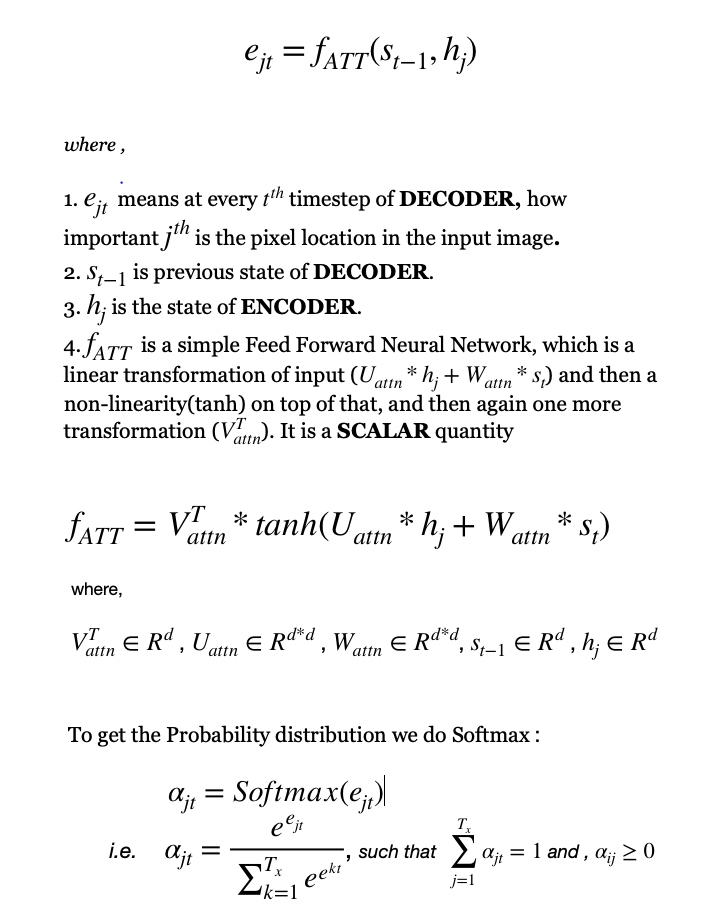

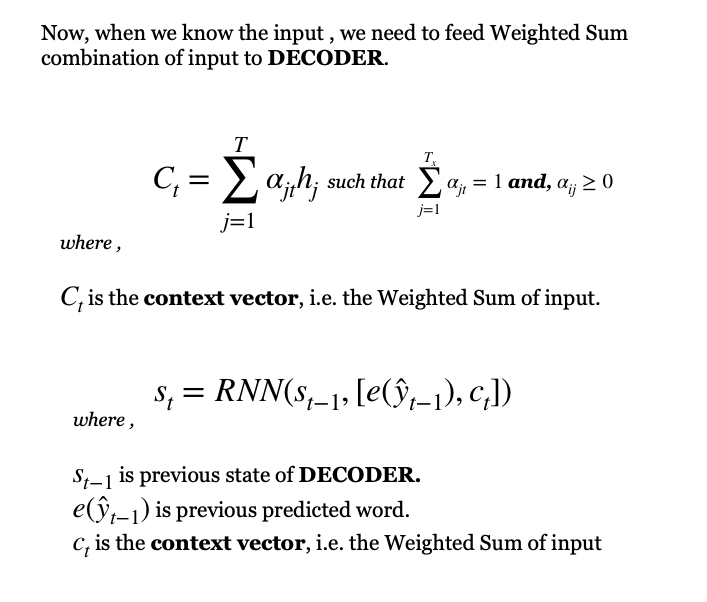

### Downloading Inception and freezing it.

In [31]:
 from keras.models import Model,Sequential
from keras.applications.inception_v3 import InceptionV3,preprocess_input
from keras.utils import to_categorical
from keras.utils import plot_model
from keras.models import Model
from keras.layers import Input
from keras.layers import Dense, BatchNormalization
from keras.layers import LSTM,Lambda,Reshape
from keras.layers import Embedding
from keras.layers import Dropout,Concatenate
from keras.layers.merge import add
from keras.callbacks import ModelCheckpoint
from keras.preprocessing.image import img_to_array
from sklearn.utils import shuffle


In [32]:


incep=InceptionV3(input_shape=(img_dimensions,img_dimensions,3),include_top=False)
incep.trainable=False
incep.summary()

87916544/87910968 [==============================] - 1s 0us/step
Model: "inception_v3"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 299, 299, 3) 0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 149, 149, 32) 864         input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization (BatchNorma (None, 149, 149, 32) 96          conv2d[0][0]                     
__________________________________________________________________________________________________
activation (Activation)         (None, 149, 149, 32) 0           batch_normalization[0][0]        
______________________

In [33]:
encoder=Sequential([Lambda(preprocess_input,input_shape=(img_dimensions,img_dimensions,3),name="preprocessing_layer"),
                    incep,
                    Dense(encoding_size,activation='relu',name="encoding_layer"),
                    Reshape((8*8,encoding_size),name="reshape_layer")],name="Encoder")
encoder.summary()

Model: "Encoder"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
preprocessing_layer (Lambda) (None, 299, 299, 3)       0         
_________________________________________________________________
inception_v3 (Functional)    (None, 8, 8, 2048)        21802784  
_________________________________________________________________
encoding_layer (Dense)       (None, 8, 8, 512)         1049088   
_________________________________________________________________
reshape_layer (Reshape)      (None, 64, 512)           0         
Total params: 22,851,872
Trainable params: 1,049,088
Non-trainable params: 21,802,784
_________________________________________________________________


### Completing the model

#### Building the attention mechanism

This is Bahdanau attention, A Soft attention that work through `linear combination of previous state and the whole image.`

Example of working explanation

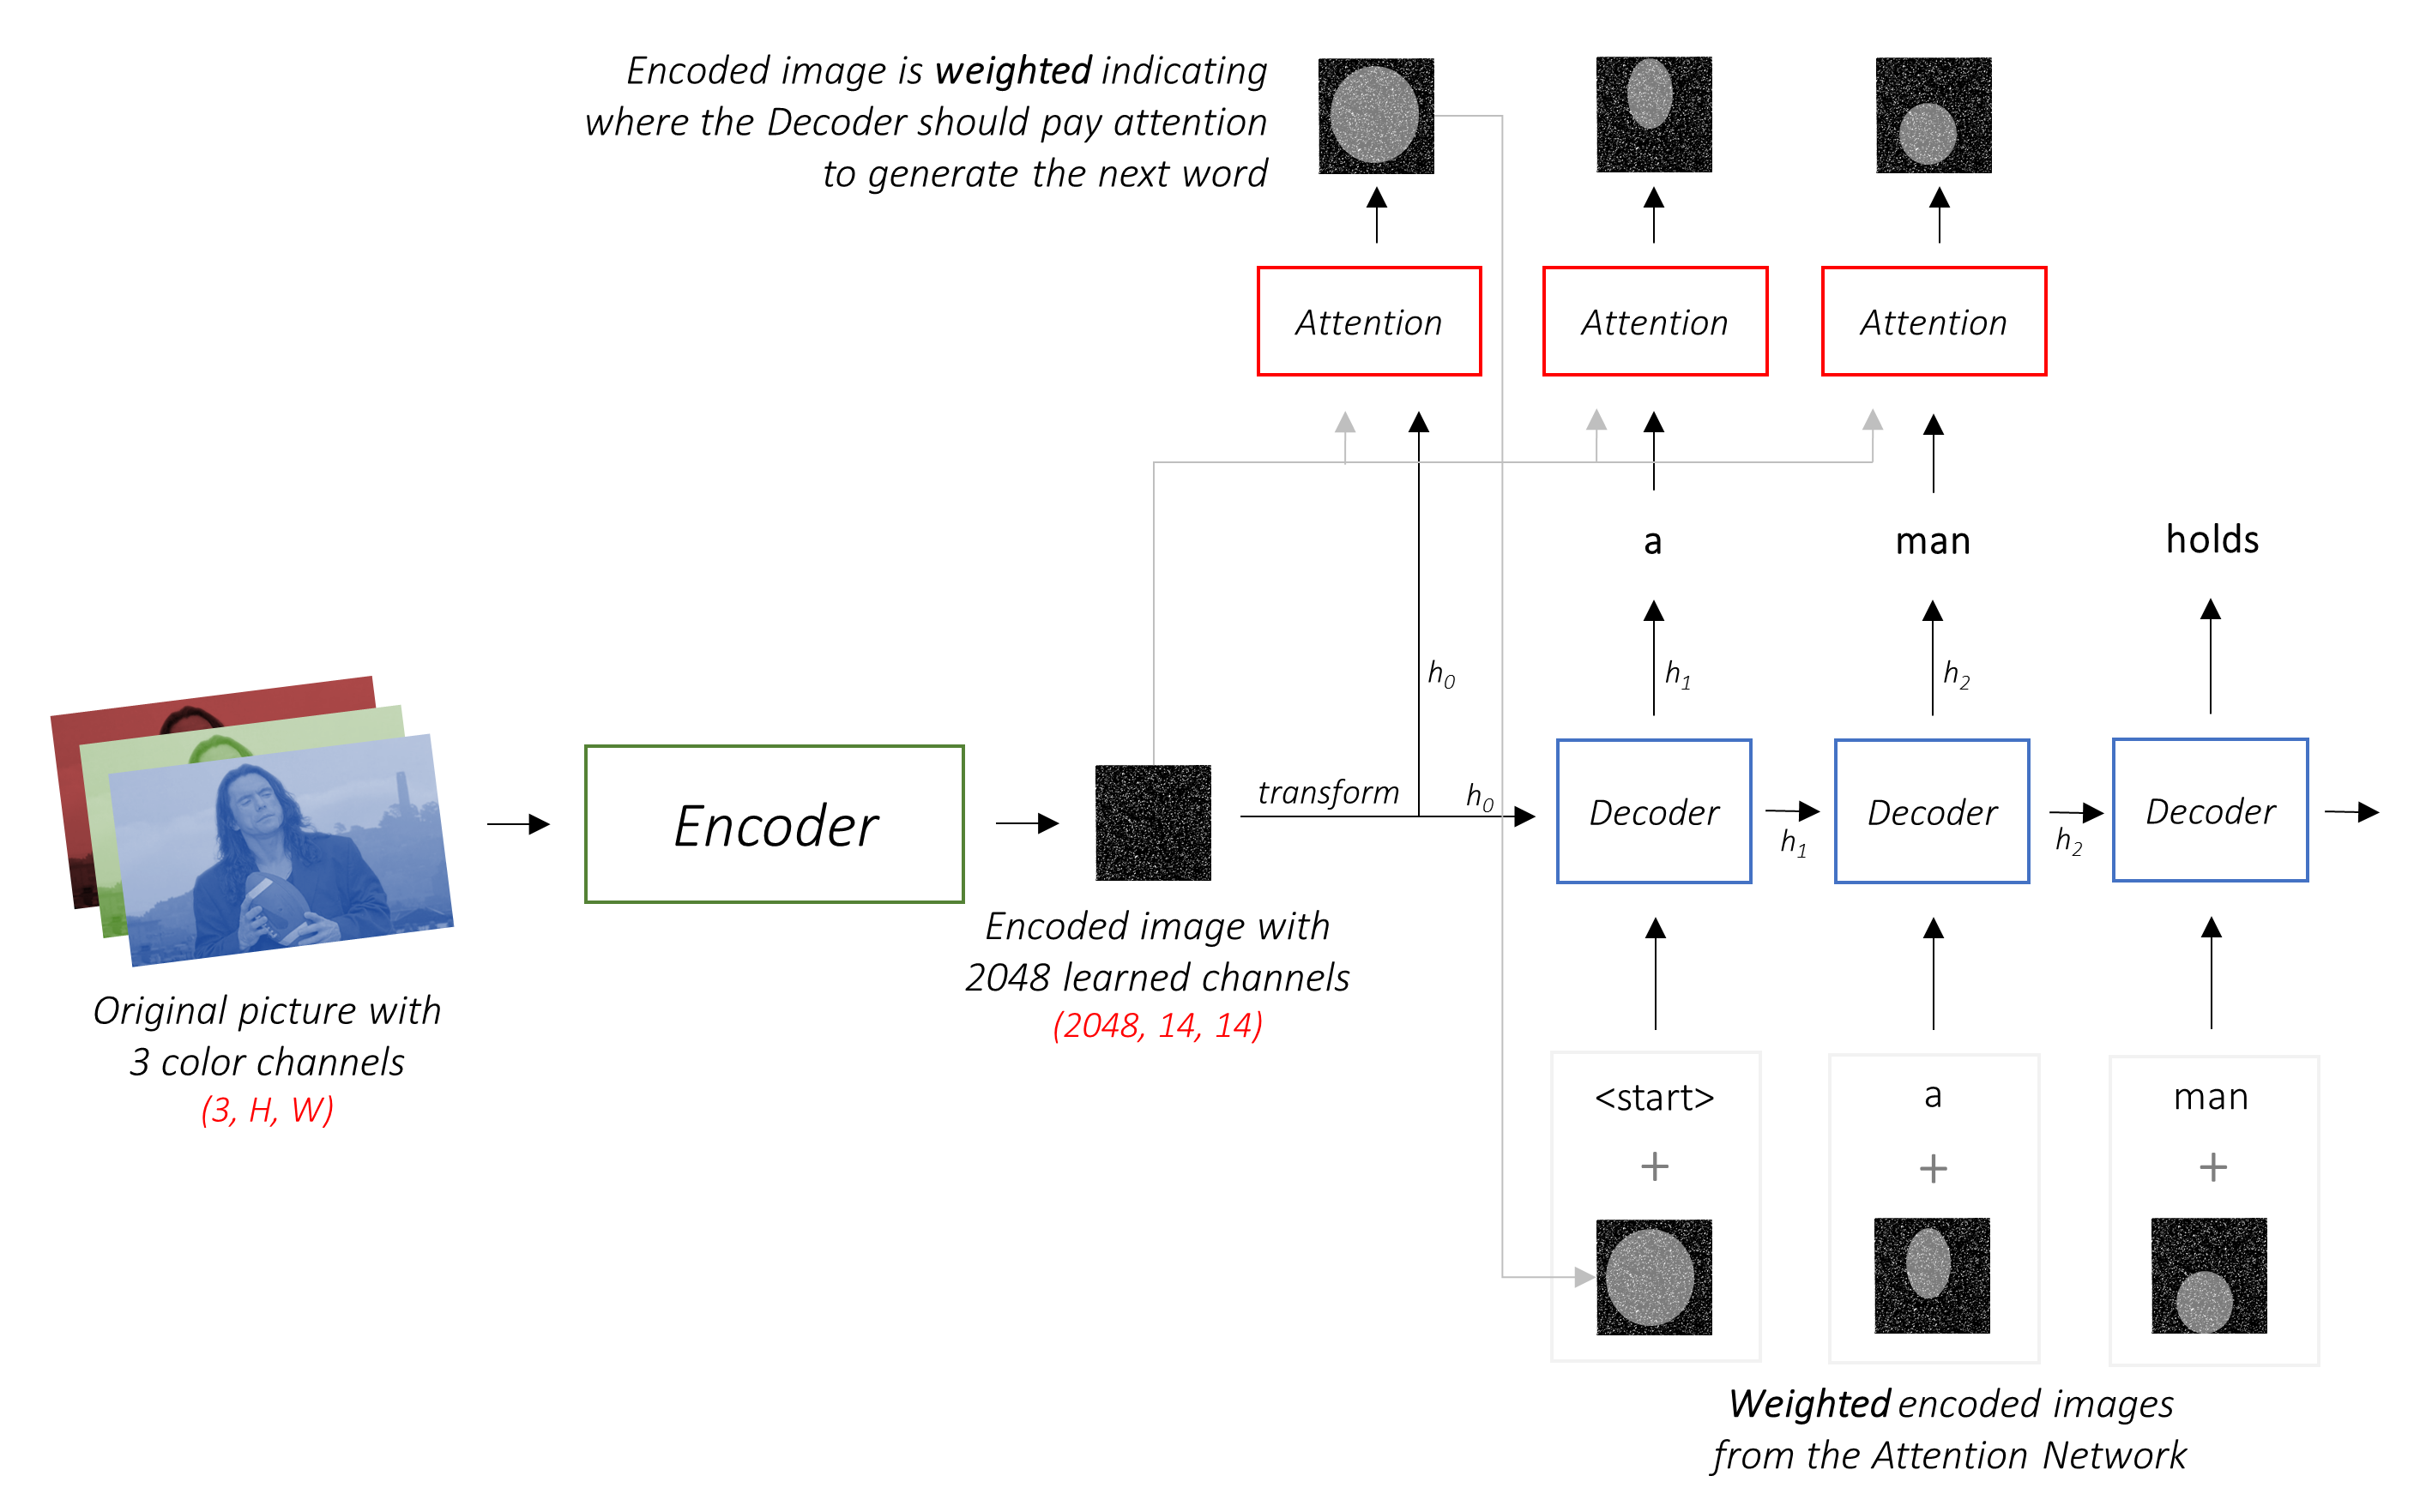

In [34]:
W1=Dense(512,name="W1")
W2=Dense(512,name="W2")
V=Dense(1,name="V")
repeater = keras.layers.RepeatVector(8*8)
doter = keras.layers.Dot(axes=1)
concatenator = keras.layers.Concatenate()

# enc(CNN_encoder output) shape == (batch_size, 64, encoding_size)
# hidden shape == (batch_size, hidden_size)

def attention_step(enc,h_prev):
  h=repeater(h_prev)
  score=tf.nn.tanh(W1(enc)+W2(h))

  alphas=tf.nn.softmax(V(score),axis=1)

  context=doter([alphas,enc])
  return context

#### Building the decoder

This decoder goes one time-step at a time
So, a custom training function is required

In [35]:
encodings=Input(shape=(8*8,encoding_size))

init_h=Input(shape=(LSTM_size))     #initial hidden state
init_c=Input(shape=(LSTM_size))     # initial c state

teacher_forcing=Input(shape=(1))

#words- 10,000(vocab size)
embedding_layer=Embedding(words+1,256,)    # embedding layer- Turns positive integers (indexes) into dense vectors of fixed size which explain the mening of word.

context_prev_tar_concat_layer = Concatenate()
decoder_lstm_layer = LSTM(LSTM_size,return_state=True,dropout=0.2)
decoder_dense_layer = Dense(words+1,activation='softmax')

h = init_h

c = init_c

context = attention_step(encodings,h)

embedds = embedding_layer(teacher_forcing)

decoder_lstm_input = context_prev_tar_concat_layer([context,embedds])
  
h , _ , c = decoder_lstm_layer(decoder_lstm_input,initial_state=[h,c])
  
out = decoder_dense_layer(h)

decoder = Model([encodings,init_h,init_c,teacher_forcing],[out,h,c])
decoder.summary()


Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_3 (InputLayer)            [(None, 512)]        0                                            
__________________________________________________________________________________________________
input_2 (InputLayer)            [(None, 64, 512)]    0                                            
__________________________________________________________________________________________________
repeat_vector (RepeatVector)    (None, 64, 512)      0           input_3[0][0]                    
__________________________________________________________________________________________________
W1 (Dense)                      (None, 64, 512)      262656      input_2[0][0]                    
______________________________________________________________________________________________

# Defining custom loss function
This loss function masks the padded steps and also one-hot enodes the targets




In [36]:
def sparse_it_up(real, pred):
  mask = tf.math.logical_not(tf.math.equal(real, 0))  # Returns the truth value of NOT x element-wise.

  real = tf.cast(real,tf.int64)       # Casts a tensor to a new type.

  real = tf.one_hot(real,words+1,axis=-1)   #Returns a one-hot tensor.

# Computes the categorical crossentropy loss- log loss.

# DOCS:
# Standalone usage:

# >>> y_true = [[0, 1, 0], [0, 0, 1]]
# >>> y_pred = [[0.05, 0.95, 0], [0.1, 0.8, 0.1]]
# >>> loss = tf.keras.losses.categorical_crossentropy(y_true, y_pred)
# >>> assert loss.shape == (2,)
# >>> loss.numpy()
# array([0.0513, 2.303], dtype=float32)
# Args:
#   y_true: Tensor of one-hot true targets.
#   y_pred: Tensor of predicted targets.
# that's why need to convert real into one-hot vector
  loss_ = tf.losses.categorical_crossentropy(real, pred)    

  mask = tf.cast(mask, dtype=tf.float32)

  loss_ *= mask

  return tf.reduce_mean(loss_)

# Defining the custom train loop
This custorm training loop was inspired from the google documentation linked above aswell.



In [37]:
optimizer = keras.optimizers.Adam()

@tf.function
def train_step(img,init_state,teacher,target):
  with tf.GradientTape() as tape:

    encodings = encoder(img)
    h = init_state
    c = init_state
    loss = 0
    for i in range(max_cap_len+1):
      dec_inp = teacher[:,i:i+1]
      o, h , c = decoder([encodings,h,c,dec_inp])

      loss += sparse_it_up(target[:,i],o) 

  total_loss = (loss / int(target.shape[1]))

  trainable_variables = encoder.trainable_variables + decoder.trainable_variables

  gradients = tape.gradient(loss, trainable_variables)

  optimizer.apply_gradients(zip(gradients, trainable_variables))

  return loss, total_loss


In [38]:
'''This function is for forward passing features for calculating losses with no backprop'''
@tf.function
def valid_step(img,init_state,teacher,target):
  with tf.GradientTape() as tape:

    encodings = encoder(img)
    h = init_state
    c = init_state
    loss = 0
    for i in range(max_cap_len+1):
      dec_inp = teacher[:,i:i+1]
      o, h , c = decoder([encodings,h,c,dec_inp])

      loss += sparse_it_up(target[:,i],o) 

  return loss

# Training the model

One training epoch takes about 35 minutes on google colab with gpu.

So, get busy doing something else for a while! or just go for a smaller num_examples set from the configuration cell.


In [31]:
EPOCHS = 5

prev_loss = np.inf

for epoch in range(EPOCHS):
    start = time.time()
    total_loss = 0

    for (batch, ((img, s, teacher) ,target)) in enumerate(dataset):
        batch_loss, t_loss = train_step(img, s, teacher ,target)
        total_loss += t_loss

        if batch % 50 == 0:
            print ('Epoch {} Batch {} Loss {:.4f}'.format(
              epoch + 1, batch, batch_loss.numpy() / int(target.shape[1])))
    
    val_loss=0

    for (i, ((img, s, teacher) ,target)) in enumerate(dataset_val):
      val_loss += valid_step(img, s, teacher ,target)
    
    val_loss = val_loss.numpy()/((i+1)*(max_cap_len+1))
    print("val_loss=",val_loss)
    
    #This code makes sure we only save the best val_loss score weights
    if val_loss < prev_loss:
      print("Model_imporved. Saving..")

      encoder.save("/content/drive/MyDrive/image_caption_data/encoder.hdf5")
      decoder.save("/content/drive/MyDrive/image_caption_data/decoder.hdf5")
    
    else:
      print("Model didn't imporve.")

    prev_loss = val_loss

Epoch 1 Batch 0 Loss 5.4113
Epoch 1 Batch 50 Loss 3.4905
Epoch 1 Batch 100 Loss 3.5625
Epoch 1 Batch 150 Loss 3.5081
Epoch 1 Batch 200 Loss 3.4704
Epoch 1 Batch 250 Loss 3.3887
Epoch 1 Batch 300 Loss 3.0388
Epoch 1 Batch 350 Loss 2.8265
Epoch 1 Batch 400 Loss 2.5917
Epoch 1 Batch 450 Loss 2.4422
Epoch 1 Batch 500 Loss 2.4955
Epoch 1 Batch 550 Loss 2.4520
Epoch 1 Batch 600 Loss 2.4928
Epoch 1 Batch 650 Loss 2.1891
Epoch 1 Batch 700 Loss 2.2370
Epoch 1 Batch 750 Loss 2.1408
Epoch 1 Batch 800 Loss 2.2319
Epoch 1 Batch 850 Loss 1.9946
Epoch 1 Batch 900 Loss 2.0722
Epoch 1 Batch 950 Loss 2.1098
Epoch 1 Batch 1000 Loss 2.1831
Epoch 1 Batch 1050 Loss 2.1266
Epoch 1 Batch 1100 Loss 2.0756
Epoch 1 Batch 1150 Loss 2.0748
Epoch 1 Batch 1200 Loss 2.1118
Epoch 1 Batch 1250 Loss 2.0848
Epoch 1 Batch 1300 Loss 2.0042
Epoch 1 Batch 1350 Loss 1.9722
Epoch 1 Batch 1400 Loss 1.9921
Epoch 1 Batch 1450 Loss 2.0336
Epoch 1 Batch 1500 Loss 1.8584
Epoch 1 Batch 1550 Loss 2.0281
Epoch 1 Batch 1600 Loss 1.8598


In [39]:
# loading the best validation accuracy score weight
encoder.load_weights("/content/drive/MyDrive/image_caption_data/encoder.hdf5")
decoder.load_weights("/content/drive/MyDrive/image_caption_data/decoder.hdf5")

# Prediction function

This function takes its input as path of an image and captions it.

In [40]:
!pip install gtts

In [41]:
import IPython
import random
# Import the required module for text  
# to speech conversion 
from gtts import gTTS 

In [54]:
def caption_image(path):
  image = load_img(path)

  
  encodings = encoder.predict(tf.reshape(image,(1,img_dimensions,img_dimensions,3)))

  texts = ["<sos>"]
  h = np.zeros((1,LSTM_size))
  c = np.zeros((1,LSTM_size))
  for _ in range(max_cap_len + 1):
    dec_inp = np.array(tok.word_index.get(texts[-1])).reshape(1,-1)
    #print(dec_inp)
    props,h,c = decoder.predict([encodings,h,c ,dec_inp])
    props= props[0]
    idx = np.argmax(props)
    
    texts.append(tok.index_word.get(idx))
    
    if idx == tok.word_index['<eos>']:
      break
  if tok.word_index.get(texts[-1]) != tok.word_index['<eos>']:
    texts.append('<eos>')
  description=' '.join(texts)
  plt.imshow(image/255.0)
  plt.axis("off")
  print(description)
  description=description[6:len(description)-5]
  
  
  language = "en"
  speech = gTTS(text = description, lang = language, slow = False)
  speech.save("Audio.mp3")

# Playing the converted file 
  IPython.display.Audio("Audio.mp3")

  

In [55]:
# Predicting on sample images

In [56]:
img_name_vector_test[1700]

'/content/train2014/COCO_train2014_000000378848.jpg'

In [57]:
img=load_img(img_name_vector_test[170])

<sos> pizza with pier and paper on it <eos>


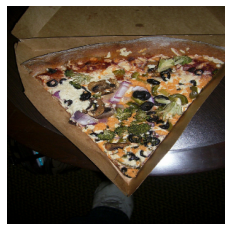

In [90]:
caption_image(img_name_vector_test[1701])

In [91]:
# Playing the converted file 
IPython.display.Audio("Audio.mp3")

<sos> zebra standing next to car in batter <eos>


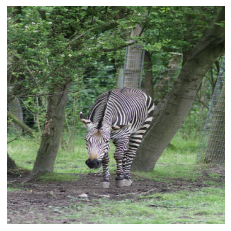

In [92]:
caption_image(img_name_vector_test[101])

In [93]:
# Playing the converted file 
IPython.display.Audio("Audio.mp3")

<sos> plane bear with sized zebras on it <eos>


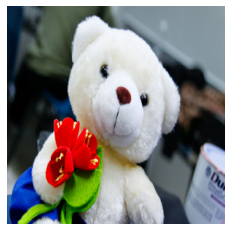

In [76]:
caption_image(img_name_vector_test[510])

<sos> woman in lamb group is holding skis <eos>


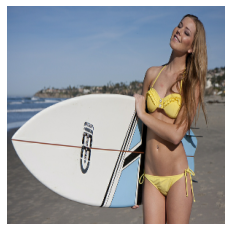

In [77]:
caption_image(img_name_vector_test[1001])

<sos> wall mens truck is parked in grass <eos>


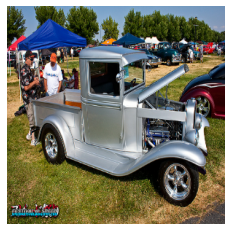

In [62]:
caption_image(img_name_vector_test[1740])

<sos> black and white cat standing in his of patch phones <eos>


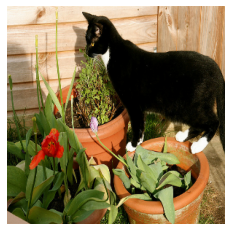

In [87]:
caption_image(img_name_vector_test[1725])

<sos> man toilet picture living bathroom train surfboard <eos>


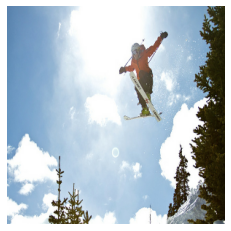

In [64]:
caption_image(img_name_vector_test[140])

<sos> airplanes bear is standing on having <eos>


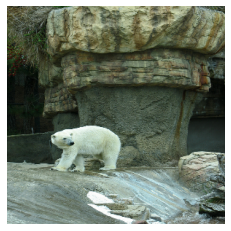

In [65]:
caption_image(img_name_vector_test[174])

<sos> display case filled with lots of different kinds of donuts <eos>


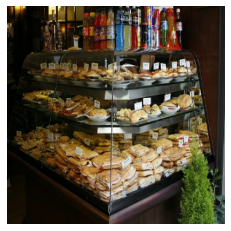

In [43]:
caption_image(img_name_vector_test[1340])